In [1]:
import numpy as np ## for linear algebra
import pandas as pd ## data processing, import data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [53]:
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import keras
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

In [3]:
os.getcwd()
os.chdir("D:\Project\Kaggle")

In [4]:
df = pd.read_csv("data/BlackFriday.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [5]:
df.head()
## there are NA values in Product Categories

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [6]:
# What could be the possible cases?
## Who is more likely to spend in BF sale?
    ## Men or women
    ## Married or unmarried
    ## Old residents or new 
## Which types of products are more likely to be sold?
## Which type of products are preferred among each gender?
## Predict Age, Gender, Purchase based on rest of the data
## Recommendation
    ## Suggest products based on Age, Location, Gender

In [7]:
df.isna().any()
## code to use to detect NA values among the entire dataset

User_ID                       False
Product_ID                    False
Gender                        False
Age                           False
Occupation                    False
City_Category                 False
Stay_In_Current_City_Years    False
Marital_Status                False
Product_Category_1            False
Product_Category_2             True
Product_Category_3             True
Purchase                      False
dtype: bool

In [8]:
# let's check unique values in the null-containing columns
print("Product_Category_2:", df["Product_Category_2"].unique())
print("Product_Category_3:", df["Product_Category_3"].unique())

Product_Category_2: [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Product_Category_3: [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]


In [9]:
# since all values are integer, let's get rid of NA values by replacing it with zero
df.fillna(value=0, inplace=True)

In [10]:
# additionally since some data types are in float 64, let's change it to integer
df["Product_Category_2"] = df["Product_Category_2"].astype(int)
df["Product_Category_3"] = df["Product_Category_3"].astype(int)

# Data Visualization

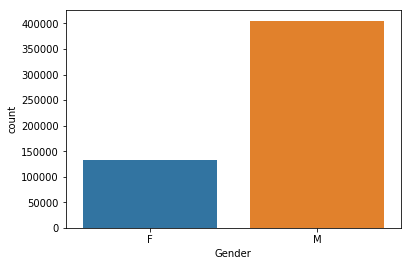

In [11]:
sns.countplot(df["Gender"])

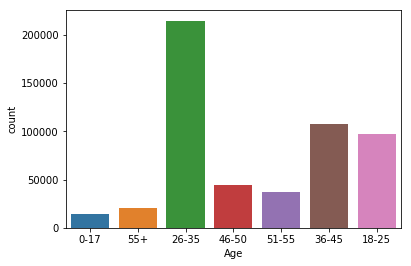

In [12]:
sns.countplot(df["Age"])

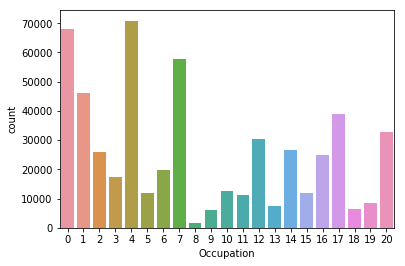

In [13]:
sns.countplot(df["Occupation"])

In [14]:
df["Occupation"].sum()
## concatenate occupations and divide them into 6 groups to minimize categorical values

4345079

In [15]:
def f(df) :
    if (df["Occupation"] >=0) & (df["Occupation"] <3):
        return "0"
    elif (df["Occupation"] >=3) & (df["Occupation"] <5):
        return "1"
    elif (df["Occupation"] >=5) & (df["Occupation"] <8):
        return "2"
    elif (df["Occupation"] >=8) & (df["Occupation"] <15):
        return "3"
    else:
        return "4"
df["Occupation"] = df.apply(lambda df: f(df), axis=1)

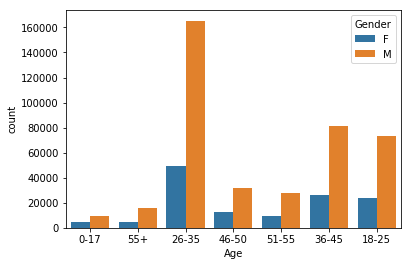

In [16]:
sns.countplot(df["Age"], hue=df["Gender"])
## to see gender distribution by age range

# Feature Engineering

In [17]:
# column names
df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

**[Feature 1]** Purchase Count per User

In [18]:
f1 = df.groupby("User_ID")["Purchase"].agg([("Purchase_Count", "count")]).reset_index()
f1.head()

,User_ID,Purchase_Count
0,1000001,34
1,1000002,76
2,1000003,29
3,1000004,13
4,1000005,106


**[Feature 2]** Main Purchase City

In [19]:
f2 = df.groupby("User_ID")["City_Category"].agg([("Main_City", lambda x: x.value_counts().index[0])]).reset_index()
f2.head()

,User_ID,Main_City
0,1000001,A
1,1000002,C
2,1000003,A
3,1000004,B
4,1000005,A


**[Feature 3]** Combine Gender

In [20]:
f3 = df.groupby("User_ID")["Gender"].agg([("Gender", lambda x: x.value_counts().index[0])]).reset_index()

**[Feature 4]** Combine Age | Replace Age range that are sparse

In [21]:
df.Age.value_counts()

26-35    214690
36-45    107499
18-25     97634
46-50     44526
51-55     37618
55+       20903
0-17      14707
Name: Age, dtype: int64

In [22]:
df["Age"] = df["Age"].replace("0-17", "18-25")
df["Age"] = df["Age"].replace("51-55", "46-50")
df["Age"] = df["Age"].replace("55+", "46-50")
df["Age"] = df["Age"].replace("18-25", "0-25")
df["Age"] = df["Age"].replace("46-50", "46+")
df["Age"].value_counts()

26-35    214690
0-25     112341
36-45    107499
46+      103047
Name: Age, dtype: int64

In [23]:
f4 = df.groupby("User_ID")["Age"].agg([("Age", lambda x: x.value_counts().index[0])]).reset_index()
f4.head()

,User_ID,Age
0,1000001,0-25
1,1000002,46+
2,1000003,26-35
3,1000004,46+
4,1000005,26-35


**[Feature 5]** Combine Occupation

In [24]:
df["Occupation"].value_counts()

0    139936
4    123479
3     96321
2     89613
1     88228
Name: Occupation, dtype: int64

In [25]:
f5 = df.groupby("User_ID")["Occupation"].agg([("Occupation", lambda x: x.value_counts().index[0])]).reset_index()

**[Feature 6]** Combine Marital Status

In [27]:
f6 = df.groupby("User_ID")["Marital_Status"].agg([("Marital_Status", lambda x: x.value_counts().index[0])]).reset_index()

**[Feature 7]** Total Purchase per User

In [28]:
f7 = df.groupby("User_ID")["Purchase"].agg([("Total_Purchase", "sum")]).reset_index()
f7.head()

,User_ID,Total_Purchase
0,1000001,333481
1,1000002,810353
2,1000003,341635
3,1000004,205987
4,1000005,821001


**[Feature 8]** Average Purchase per User

In [29]:
f8 = df.groupby("User_ID")["Purchase"].agg([("Avg_Purchase", "mean")]).astype(int).reset_index()

**[Feature 9]** Old and New Residents | New: 0-2 | Old: 3+

In [30]:
df["Stay_In_Current_City_Years"].value_counts()

1     189192
2      99459
3      93312
4+     82889
0      72725
Name: Stay_In_Current_City_Years, dtype: int64

In [31]:
df["Resident"] = df["Stay_In_Current_City_Years"].copy()
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Resident
0,1000001,P00069042,F,0-25,3,A,2,0,3,0,0,8370,2
1,1000001,P00248942,F,0-25,3,A,2,0,1,6,14,15200,2
2,1000001,P00087842,F,0-25,3,A,2,0,12,0,0,1422,2
3,1000001,P00085442,F,0-25,3,A,2,0,12,14,0,1057,2
4,1000002,P00285442,M,46+,4,C,4+,0,8,0,0,7969,4+


In [32]:
df["Resident"] = df["Resident"].replace("0", "1")
df["Resident"] = df["Resident"].replace("3", "2")
df["Resident"] = df["Resident"].replace("4+", "2")
df["Resident"] = df["Resident"].replace("2", "old")
df["Resident"] = df["Resident"].replace("1", "new")

In [33]:
df.Resident.value_counts()

old    275660
new    261917
Name: Resident, dtype: int64

In [34]:
f9 = df.groupby("User_ID")["Resident"].agg([("Resident", lambda x: x.value_counts().index[0])]).reset_index()

**[Feature 10]** Combine Stay in Current City Years

In [35]:
f10 = df.groupby("User_ID")["Stay_In_Current_City_Years"].agg([("City_Year", lambda x: x.value_counts().index[0])]).reset_index()

**[Feature 11]** Combine Product Category 1

In [36]:
f11 = df.groupby("User_ID")["Product_Category_1"].agg([("Product_Category_1", lambda x: x.value_counts().index[0])]).reset_index()

**[Feature 12]** Combine Purchase

In [37]:
f12 = df.groupby("User_ID")["Purchase"].agg([("Purchase", lambda x: x.value_counts().index[0])]).reset_index()

**[Merge Feature Variables]**

In [38]:
df = f1.\
merge(f2, on="User_ID", how="left").\
merge(f3, on="User_ID", how="left").\
merge(f4, on="User_ID", how="left").\
merge(f5, on="User_ID", how="left").\
merge(f6, on="User_ID", how="left").\
merge(f7, on="User_ID", how="left").\
merge(f8, on="User_ID", how="left").\
merge(f9, on="User_ID", how="left").\
merge(f10, on="User_ID", how="left").\
merge(f11, on="User_ID", how="left").\
merge(f12, on="User_ID", how="left")

In [39]:
df.drop(columns = ["User_ID"], inplace=True)

In [40]:
## getting dummies for multivalue columns
df = pd.get_dummies(df, columns=["Main_City", "Age", "City_Year", "Occupation", "Resident", "Product_Category_1"])

In [41]:
df.to_csv("Black_Friday_self.csv")

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5891 entries, 0 to 5890
Data columns (total 40 columns):
Purchase_Count           5891 non-null int64
Gender                   5891 non-null object
Marital_Status           5891 non-null int64
Total_Purchase           5891 non-null int64
Avg_Purchase             5891 non-null int32
Purchase                 5891 non-null int64
Main_City_A              5891 non-null uint8
Main_City_B              5891 non-null uint8
Main_City_C              5891 non-null uint8
Age_0-25                 5891 non-null uint8
Age_26-35                5891 non-null uint8
Age_36-45                5891 non-null uint8
Age_46+                  5891 non-null uint8
City_Year_0              5891 non-null uint8
City_Year_1              5891 non-null uint8
City_Year_2              5891 non-null uint8
City_Year_3              5891 non-null uint8
City_Year_4+             5891 non-null uint8
Occupation_0             5891 non-null uint8
Occupation_1             5891 non-nul

# Data Pre-processing

**[Predicting Gender]**

In [43]:
df = pd.read_csv("Black_Friday_self.csv", index_col=0)

In [44]:
# encode labeling
le = LabelEncoder()
## binary labeling
binary_cat = ["Gender", "Marital_Status"]
for i in binary_cat:
    df[i] = le.fit_transform(df[i])

In [45]:
df.head()

,Purchase_Count,Gender,Marital_Status,Total_Purchase,Avg_Purchase,Purchase,Main_City_A,Main_City_B,Main_City_C,Age_0-25,...,Product_Category_1_6,Product_Category_1_7,Product_Category_1_8,Product_Category_1_10,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_15,Product_Category_1_16,Product_Category_1_18
0,34,0,0,333481,9808,15416,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,76,1,0,810353,10662,10074,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,29,1,0,341635,11780,19327,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13,1,1,205987,15845,15485,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,106,1,1,821001,7745,5895,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
X = df.drop("Gender", axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = np_utils.to_categorical(df["Gender"], 2)

C:\Users\irie9\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [49]:
BATCH_SIZE = 32
EPOCHS = 30
OPTIM = Adam(lr=.001)

In [54]:
model = Sequential()
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(.2))

model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dropout(.2))

model.add(Dense(2))
model.add(Activation("softmax"))
model.compile(loss="binary_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

Train on 4712 samples, validate on 1179 samples
Epoch 1/30
4712/4712 [==============================] - 1s 161us/step - loss: 0.5870 - acc: 0.7180 - val_loss: 0.5861 - val_acc: 0.7014
Epoch 2/30
4712/4712 [==============================] - 0s 37us/step - loss: 0.5678 - acc: 0.7199 - val_loss: 0.5831 - val_acc: 0.7014
Epoch 3/30
4712/4712 [==============================] - 0s 37us/step - loss: 0.5638 - acc: 0.7213 - val_loss: 0.5757 - val_acc: 0.7014
Epoch 4/30
4712/4712 [==============================] - 0s 37us/step - loss: 0.5580 - acc: 0.7207 - val_loss: 0.5730 - val_acc: 0.7014
Epoch 5/30
4712/4712 [==============================] - 0s 37us/step - loss: 0.5552 - acc: 0.7205 - val_loss: 0.5721 - val_acc: 0.7014
Epoch 6/30
4712/4712 [==============================] - 0s 43us/step - loss: 0.5544 - acc: 0.7220 - val_loss: 0.5713 - val_acc: 0.7014
Epoch 7/30
4712/4712 [==============================] - 0s 35us/step - loss: 0.5511 - acc: 0.7222 - val_loss: 0.5723 - val_acc: 0.7014
Epoch 